# Classification de peintures :
### Aivazovsky, Van Gogh, Cortes et Renoir

# Introduction

## Accroche : musée

## Présentation de la technologie :

![schema](https://image.noelshack.com/fichiers/2019/15/4/1554991976-screenshot-1.png)

## Présentation de Data set peinture : source Google images / Kaggle :

<br>

## 1) Configuration du notebook 

Ces trois lignes sont propres à Jupyter et ne sont pas du Python :
elles servent à actualiser le code en cas de changement de librairie et de bien afficher les plots de matplotlib sur le notebook.

In [3]:
%reload_ext autoreload
%autoreload 2<br>
%matplotlib inline

On importe avec * tous les élements du module vision de la librairie FastAI et l'élément <strong>error_rate</strong> et <strong>accuracy</strong>  du module metrics.<br>
Metrics : Similarité entre deux éléments d'un même ensemble.
Ainsi que le package google_images_download afin d'importer nos images.

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.metrics import accuracy
from google_images_download import google_images_download

# 2) Importation des données

Utilisation de google image download pour récupérer nos peintures

In [3]:
arguments = {}
arguments["keywords"] = "Aivazovksy, VanGogh, Cortes, Renoir"
arguments["limit"] = 300
arguments["print_urls"] = False
arguments["format"] = "jpg"
arguments["color_type"] = "full-color"
arguments["type"] = "photo"
arguments["output_directory"] = "/paintings"
response = google_images_download.googleimagesdownload()
paths = response.download(arguments)

Définition du path et suppression des fichiers de sauvegardes susceptibles d'occasionner des bugs.

In [4]:
path = Path(arguments["output_directory"])

%cd '{path}'
!find '.' -name '*.ipynb_checkpoints' -exec rm -r {} +

path.ls()

/home/makramjandar/data/paintings


[PosixPath('/home/makramjandar/data/paintings/jean-michel_basquiat'),
 PosixPath('/home/makramjandar/data/paintings/frank_frazetta'),
 PosixPath('/home/makramjandar/data/paintings/edvard_munch'),
 PosixPath('/home/makramjandar/data/paintings/roy_lichtenstein'),
 PosixPath('/home/makramjandar/data/paintings/valerio_adami'),
 PosixPath('/home/makramjandar/data/paintings/james_ensor')]

Renommage des images téléchargées.

In [5]:
# name cleanup
import os
for folder in path.ls():
    i = 1
    label = str(folder).split('/')[-1]
    if label != 'models':
        for photo in folder.ls():
            new_name = f'{str(folder)}/{label}_{i}.jpg'
            os.rename(photo, new_name)
            i = i + 1

Suppression des espaces vides dans les noms des fichiers.

In [24]:
def replace(parent):
    for path, folders, files in os.walk(parent):
        for f in files:
            os.rename(os.path.join(path, f), os.path.join(path, f.replace(' ', '_')))
        for i in range(len(folders)):
            new_name = folders[i].replace(' ', '_')
            os.rename(os.path.join(path, folders[i]), os.path.join(path, new_name))
            folders[i] = new_name
replace(arguments["output_directory"])

Suppression des fichiers impossible à ouvrir.

In [6]:
for c in arguments["keywords"].split(','):
    print(c)
    path_to_class_folder = arguments["output_directory"] + "/" + c
    verify_images(path_to_class_folder, delete=True, img_format=f'{c} %d')
  

james_ensor


jean-michel_basquiat


frank_frazetta


valerio_adami


roy_lichtenstein


edvard_munch


# 3) Préparation des données

<br>

On définit le seed personnalisé afin d'avoir le même tirage aléatoire à chaque fois.<br>
On crée une variable data dans laquelle on utilise la classe FastAI ImageDataBunch.<br>
En utilisant .from_folder, on crée un dataset de style image-net ressemblant à 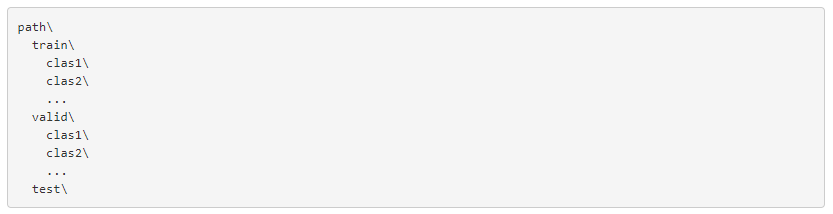<br>


On rentre comme argument le path, train qui ici prend tout, valid_pct qui correspond au pourcentage du dataset que l'on souhaite pour notre set de validation > ici 20%<br>
On définit la size des images pour qu'elles soient toutes de 224, num_workers correspond au nombre de CPUs que nous souhaitons utiliser et normalize afin d'uniformiser les niveaux des images à la même échelle.

In [4]:
np.random.seed(8)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
                                 ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

A partir de data, on lui demande d'afficher les différentes classes.

In [5]:
data.classes

['Aivazovsky', 'Cortes', 'Renoir', 'VanGogh']

On demande d'afficher l'échantillon d'images qu'on définit avec les arguments suivant:<br>
On demande quatre colonnes avec rows, et figsize l'affichage des images de la batch.

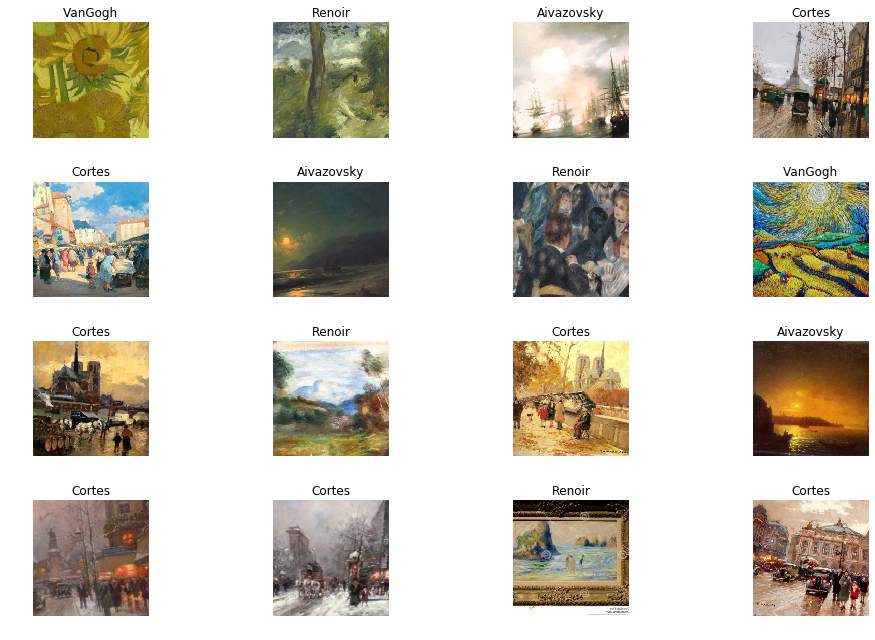

In [6]:
data.show_batch(rows=4, figsize=(14,9))

On lui demande le nom des classes, le nombre de classes, le nombre d'images dans notre training set et dans notre validation set, définit par l'argument valid_pct de la classe ImageDataBunch.

In [7]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Aivazovsky', 'Cortes', 'Renoir', 'VanGogh'], 4, 924, 231)

# 4) Création du réseau de neurone et du modèle

<br>

On initialise notre réseau de neurone avec create_cnn en lui précisant notre dataset, l'architecture ResNet et error_rate qui est notre métric permettant d'évaluer l'efficacité de notre modèle.

In [9]:
learn = cnn_learner(data, models.resnet50, metrics=(error_rate, accuracy))

On précise avec torch.device('cuda') que l'on travaille bien avec le GPU et non le CPU.

In [11]:
defaults.device = torch.device('cuda')

On demande à notre modèle d'apprendre avec la classe fit_one_cycle (1cycle policy) et en lui précisant le nombre d'epochs.

In [12]:
learn.fit_one_cycle(4)

On sauvegarde notre modèle dans le path prédéfini.

In [13]:
learn.save('paintings50_1')

# 5) Nettoyage du dataset

<br>

On importe tous les éléments du module widgets afin de les utiliser pour nettoyer nos données.

In [14]:
from fastai.widgets import *

DatasetFormatter permet de retourner le dataset avec les données sous un bon format et correctement indexé.<br>
from_toplosses permet de prendre les images pour lesquelles le modèle se trompe le plus.

In [15]:
ds, idxs = DatasetFormatter().from_toplosses(learn)

ImageCleaner est un widget qui nous permet de supprimer les images pour lesquelles on recense le plus de loss afin de les supprimer ou de les réassigner dans la bonne classe puis les réassigne dans un fichier cleaned.csv<br>
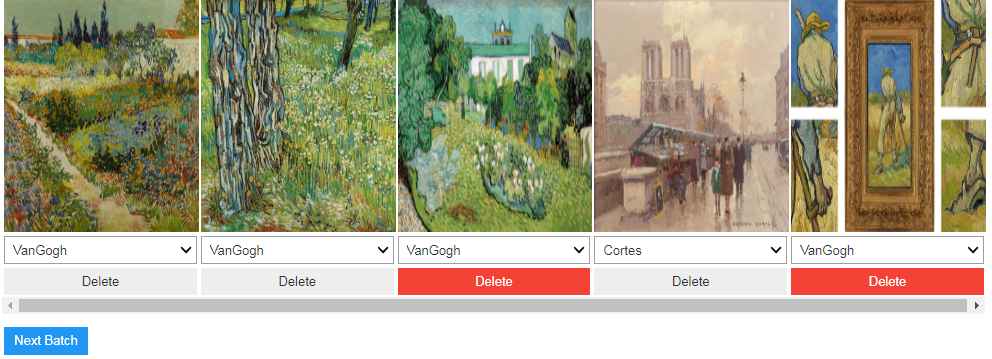

In [16]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

On utilise pandas pour lire le fichier cleaned.csv et on affiche avec head les 5 premières données avec le nom des fichiers et leurs classes.

In [17]:
df = pd.read_csv(path/'cleaned.csv', header='infer')
df.head()

name   label
0  Cortes/00000216.jpg  Cortes
1  Cortes/00000237.jpg  Cortes
2  Cortes/00000032.jpg  Cortes
3  Cortes/00000287.jpg  Cortes
4  Cortes/00000109.jpg  Cortes

On vérifie que les noms de fichiers ne sont pas corrompus.

In [18]:
df[(df['name'].apply(lambda x: len(x)<5))]

Empty DataFrame
Columns: [name, label]
Index: []

# 6) Entrainement du modèle avec le nouveau dataset nettoyé

<br>

On réaffecte un random seed de 8.<br>
On recrée l'ImageDataBunch avec notre nouveau dataset nettoyé.

In [19]:
np.random.seed(8)
db = (ImageList.from_df(df, path)
     .split_by_rand_pct(0.2)
     .label_from_df()
     .transform(get_transforms(), size=224)
     .databunch(bs=9)).normalize(imagenet_stats)

Dataset non nettoyé :

In [20]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Aivazovsky', 'Cortes', 'Renoir', 'VanGogh'], 4, 924, 231)

Dataset nettoyé :

In [21]:
db.classes, db.c, len(db.train_ds), len(db.valid_ds)

(['Aivazovsky', 'Cortes', 'Renoir', 'VanGogh'], 4, 715, 178)

On affiche une batch:

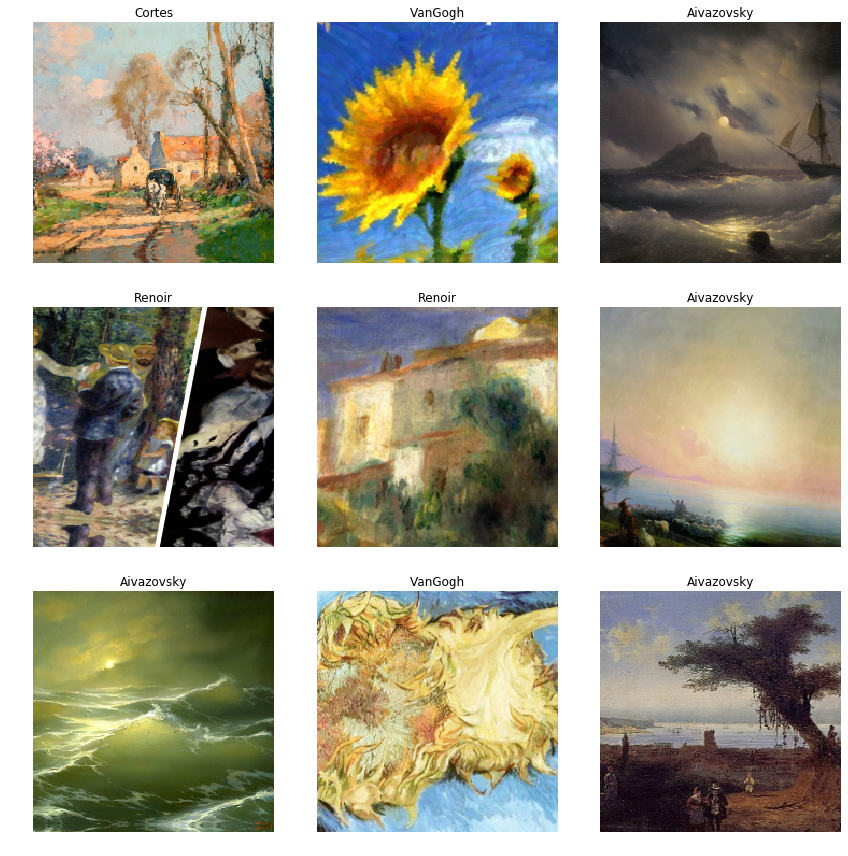

In [22]:
db.show_batch()

On réentraîne notre nouveau dataset

In [23]:
learn = cnn_learner(db, models.resnet50, metrics=(error_rate, accuracy))

In [24]:
learn.fit_one_cycle(4)

In [25]:
learn.save('paintings50_2')

In [26]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(1)

On charge notre modèle entraîné précédémment.

In [28]:
learn.load('paintings50_2')

Learner(data=ImageDataBunch;

Train: LabelList (715 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Cortes,Cortes,Cortes,Cortes,Cortes
Path: paintings;

Valid: LabelList (178 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Aivazovsky,VanGogh,Renoir,Aivazovsky,Renoir
Path: paintings;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

Permet de trouver le learning rate qu'on affiche avec recorder.plot

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


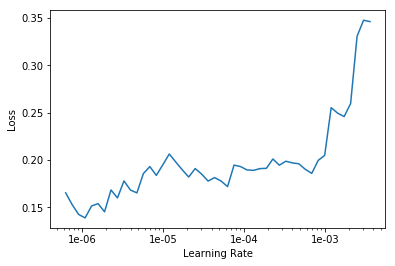

In [30]:
learn.recorder.plot()

On réentraîne le modèle selon l'intervall de learning rate choisi.

In [31]:
learn.fit_one_cycle(4, max_lr=slice(1e-5, 1e-4))

On sauvegarde le deuxième modèle.

In [32]:
learn.save('paintings50_2')

ClassificationInterpretation est une fonction FastAI qui permet d'interpreter les résultats des modèles de classification.

In [33]:
interp = ClassificationInterpretation.from_learner(learn)

In [45]:
losses,idxs = interp.top_losses()

len(db.valid_ds)==len(losses)==len(idxs)

True

On affiche les plus hautes pertes pour chaque image.

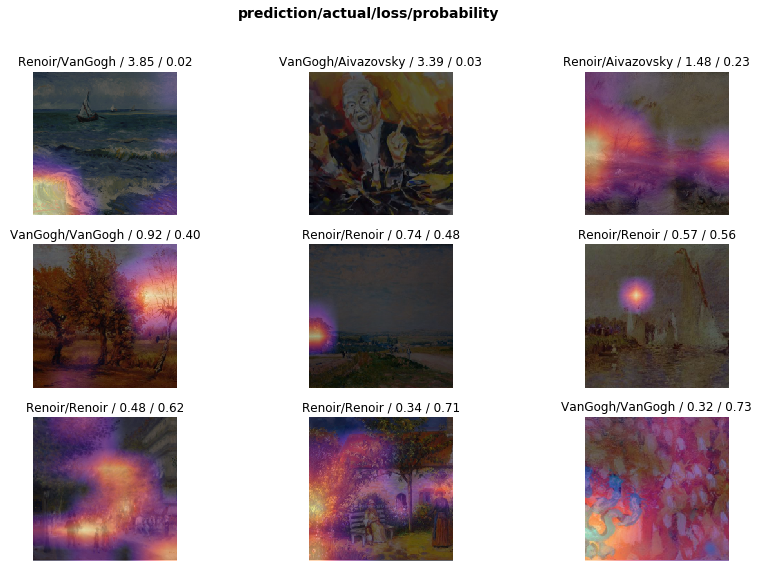

In [46]:
interp.plot_top_losses(9, figsize=(14,9))

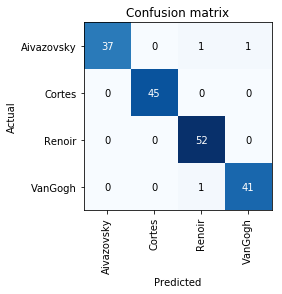

In [47]:
interp.plot_confusion_matrix()

In [48]:
interp.most_confused(min_val=1)

[('Aivazovsky', 'Renoir', 1),
 ('Aivazovsky', 'VanGogh', 1),
 ('VanGogh', 'Renoir', 1)]

# 7) Déploiement de notre modèle en ligne 

On charge notre dernier modèle

In [ ]:
learn.load('paintings50_2')

On exporte notre modèle sous format .pkl

In [ ]:
learn.export()

# https://classifpaintings.onrender.com/